In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)
set_session(sess)

### Initailize variables & Layers

In [2]:
BATCH_SIZE = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224
TRAIN_SIZE = 2000
STEPS_PER_EPOCH = np.ceil(TRAIN_SIZE /BATCH_SIZE)
input_layer = Input(shape=(IMG_HEIGHT, IMG_HEIGHT, 3))
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_HEIGHT, 3), input_tensor=input_layer)

flatten = Flatten()
dense_1 = Dense(64, activation='relu', name='additional_dense_1')
dense_2 = Dense(32, activation='relu', name='additional_dense_2')
output = Dense(2, activation='softmax', name='prediction')

#### Get block5_pool Layer from VGG Model, & Append 2 Dense Layer & Prediction Layer to Fine-Tune  the VGG Model

In [4]:
block5_pool = vgg_conv.get_layer('block5_pool')
flatten = flatten(block5_pool.output)
dense = dense_1(flatten)
dense = dense_2(dense)
output = output(dense)
model = Model(inputs=input_layer, outputs=output)

### Freeze the layers except the last 3 layers

In [5]:
for layer in model.layers[:-3]:
    layer.trainable = False
for layer in model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
additional_dense_1 True
additional_dense_2 True
prediction True


### Load Training Data & Create Training Data Generator

In [6]:
# Download data from "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_dir = 'data/cats_and_dogs/train'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_HEIGHT, IMG_HEIGHT),
        batch_size=BATCH_SIZE)


Found 2000 images belonging to 2 classes.


## Train The Model

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=2
)

Epoch 1/2
1000/1000 [==============================] - 130s 130ms/step - loss: 0.4664 - accuracy: 0.7730
Epoch 2/2
1000/1000 [==============================] - 126s 126ms/step - loss: 0.3566 - accuracy: 0.8400


## Create Grad-CAM Class

In [8]:
class GradCAM:
    
    def __init__(self, model, class_idx, layer_name=None):
        self.model=model
        self.class_idx=class_idx
        self.layer_name=layer_name
        if not layer_name:
            self.layer_name = self.find_target_layer()
        
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError('Could not find 4D layer. Cannot apply GradCAM.')

    def compute_cam(self, image, eps=1e-8):
        grad_model = tf.keras.models.Model(inputs=[self.model.inputs],
                                           outputs=[self.model.get_layer(self.layer_name).output, self.model.output])
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            conv_outs, predictions = grad_model(inputs)
            y_c = predictions[:, self.class_idx]

        # compute the gradient of the score for the class c, with respect to feature maps Ak of a convolutional layer
        grads = tape.gradient(y_c, conv_outs) 
        # compute the guided gradients Basically applying ReLU
        cast_conv_outputs = tf.cast(conv_outs > 0, tf.float32)
        cast_grads = tf.cast(grads > 0, tf.float32)
        # guided_grads = where conv_out and their gradients are both positive numbers
        guided_grads = cast_conv_outputs * cast_grads * grads 
        
        conv_outs = conv_outs[0]
        guided_grads = guided_grads[0]
        
        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with
        # respect to the weights (Global pooling average)
        weights = tf.reduce_mean(guided_grads, axis=(0, 1))
        
        # After calculating ak for the target class c, we perform a weighted combination of activation maps.
        cam = tf.reduce_sum(tf.multiply(weights, conv_outs), axis=-1)
        
        w, h = image.shape[2], image.shape[1] 
        cam = resize(cam.numpy(), (w, h))
        cam /= np.max(cam)
        cam = (cam * 255).astype("uint8")
        return cam

## Plot Images

In [30]:
def plot_images(image, cam):
    fig_size = (5, 5)
    plt.figure(figsize=fig_size)
    plt.axis('off')
    plt.imshow(image)
    plt.figure(figsize=fig_size)
    plt.axis('off')
    plt.imshow(cam)
    plt.figure(figsize=fig_size)
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()

In [31]:
classes = {'cat':0, 'dog': 1}

## Check for the region in the input responsible of for prediction Dog

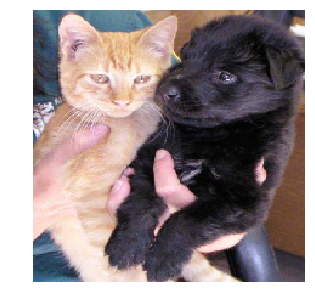

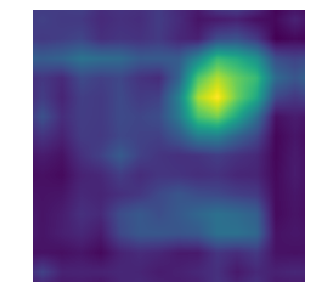

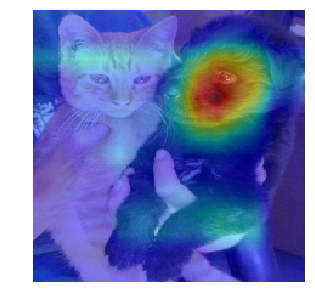

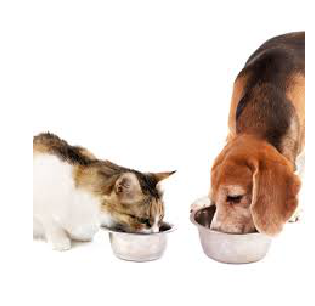

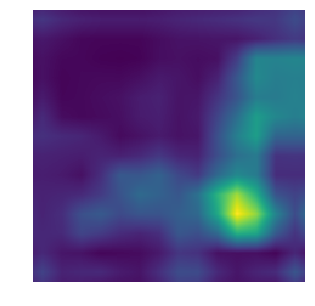

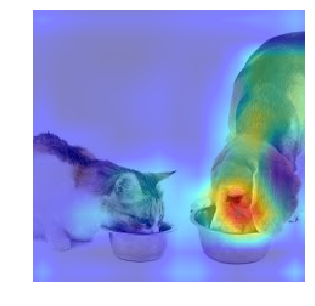

In [32]:
image_paths = ['Images/dog_cat_1.jpg', 'Images/dog_cat_2.jpg']
for image_path in image_paths:
    orig = cv2.imread(image_path)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    cam = GradCAM(model, classes['dog'], layer_name='block5_conv3')
    heatmap = cam.compute_cam(image)
    plot_images(image[0] / 255, heatmap)

## Check for the region in the input responsible of for prediction Cat

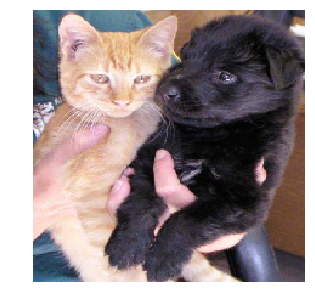

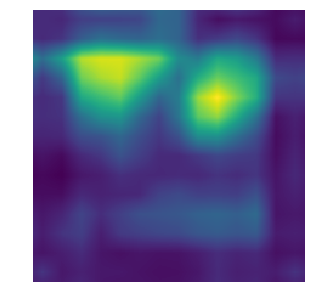

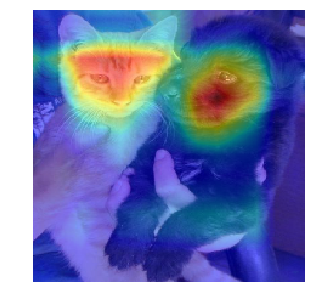

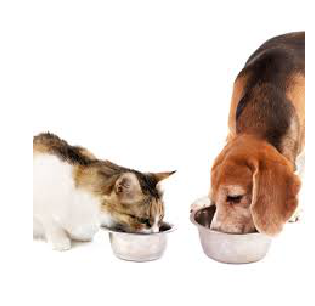

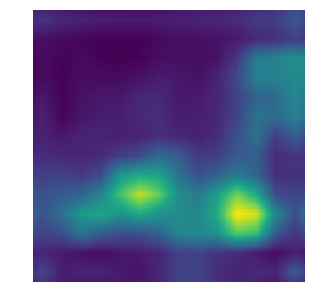

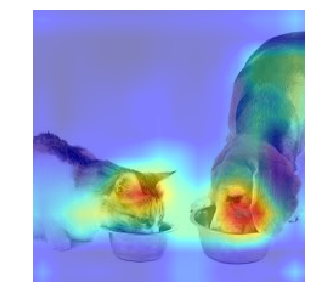

In [33]:
image_paths = ['Images/dog_cat_1.jpg', 'Images/dog_cat_2.jpg']
for image_path in image_paths:
    orig = cv2.imread(image_path)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    cam = GradCAM(model, classes['cat'], layer_name='block5_conv3')
    heatmap = cam.compute_cam(image)
    plot_images(image[0] / 255, heatmap)

* The region for cat is not clearly explained, Here region for dog is also taking part a the dominant region for predicting a cat.
* It can be improved by training the model for more number of iterations.